<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/17_Q3and2_Duolingo_novectors_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>

In this notebook we will look at Q2 and Q3 modeling and testing with both student and word based features, except that the word vector features are removed.

Caveat: we only have data that spans 2 weeks. So we will need to leave the beginning few days out (as they will need to be the basis for the features based on student behavior, so as to prevent data leakage.)

Also, some of these features depend on the student's choices for that day. If they choose to spend a session reviewing old words vs learning new ones. 

The dataset is filtered to students who have logged in at least 11 number of days, and aggregate features are calculated for 1 to 10 days to see how well they separate performance of students. 




## <font color = 'cornflowerblue' size=4>Loading data and computing aggregates</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')


import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


Loading q2train and validation sets:

In [2]:
Xq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFX.pbz2") 
yq2train = decompress_pickle(path_name+"Q2TRAIN_ALLFy.pbz2") 

Xq2valid = decompress_pickle(path_name+"Q2VALID_ALLFX.pbz2") 
yq2valid = decompress_pickle(path_name+"Q2VALID_ALLFy.pbz2") 

In [3]:
Xq2train.shape, yq2train.shape, Xq2valid.shape, yq2valid.shape

((24409, 424), (24409,), (1344, 424), (1344,))

In [4]:
yq2train.sum()/yq2train.shape[0], yq2valid.sum()/yq2valid.shape[0]

(0.15318120365438978, 0.11383928571428571)

There is a minor differences in the class sample proportions in the training and validation sets. 

Removing the word vector features:

Isolating the word vector columns

In [10]:
Xq2train.columns[124:]

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299],
      dtype='object', length=300)

Removing the word vectors from training and validation sets.

In [30]:
Xq2train = Xq2train.drop(Xq2train.columns[124:],axis=1)
Xq2train.shape

(24409, 124)

In [33]:
Xq2valid = Xq2valid.drop(Xq2valid.columns[124:],axis=1)
Xq2valid.shape

(1344, 124)

Scaling the training and validation sets:

Since there's not too much data, no down-sampling will be donw. 

In [34]:
from sklearn.preprocessing import MinMaxScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MinMaxScaler()

mm_scaler.fit(Xq2train)
Xq2_train_mm = mm_scaler.transform(Xq2train)
Xq2_valid_mm = mm_scaler.transform(Xq2valid) # downsampled scaler is applied. 


In [35]:
Xq2_train_mm.shape

(24409, 124)

Training and validation sets are ready for modeling.

## <font color='cornflowerblue' size=4>Classical models</font>



### <font color='cornflowerblue' size=3>Logistic Regression</font>

In [36]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate # return scores for many metrics

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV # to search hyperparameters in a grid 

classweight_vals = ['balanced',{0:0.01,1:0.99}]
C_vals = [10**(-3),1,10**3]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg = LogisticRegression(solver = 'lbfgs',max_iter=500)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=1,refit=False)

gridsearch_obj.fit(Xq2_train_mm,yq2train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.001, 1, 1000],
                         'class_weight': ['balanced', {0: 0.01, 1: 0.99}]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=1)

In [37]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_C','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,0.001,0.07,0.03,0.67,0.29,0.65,0.31,0.50
1,"{0: 0.01, 1: 0.99}",0.001,0.07,0.02,0.15,0.27,0.64,0.27,1.00
2,balanced,1,0.58,0.02,0.67,0.27,0.65,0.32,0.51
3,"{0: 0.01, 1: 0.99}",1,0.21,0.02,0.15,0.28,0.66,0.27,1.00
4,balanced,1000,1.84,0.02,0.67,0.27,0.65,0.32,0.51
5,"{0: 0.01, 1: 0.99}",1000,1.78,0.02,0.16,0.27,0.65,0.27,0.99


Accuracy suffers and is lower than baseline, but there is an improvement in the precision by some compared to only the student features or only the word based features. 

Selecting the best model:
With a skewed class weight, recall is good, at the expense of accuracy. 

Precision is best at a 'balanced' class weight, but with an average recall of 0.51. 

Both models (index=0 and index = 3) will be refit to see how validation set does

In [38]:
logreg = LogisticRegression(solver = 'lbfgs',max_iter=5000,class_weight='balanced',C=.001)

logreg.fit(Xq2_train_mm,yq2train)

yvalid_preds_proba = logreg.predict_proba(Xq2_valid_mm)[:,1]
ytrain_preds_proba = logreg.predict_proba(Xq2_train_mm)[:,1]

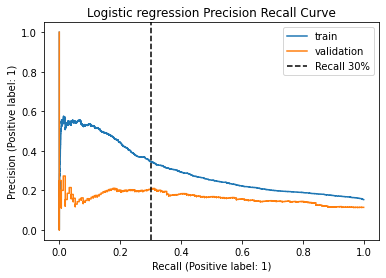

In [39]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yvalid_preds_proba)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, ytrain_preds_proba)

plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(yq2train,ytrain_preds_proba, ax=ax,label="train")
PrecisionRecallDisplay.from_predictions(yq2valid,yvalid_preds_proba, ax=ax,label="validation")

plt.title("Logistic regression Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
#precision_at_recall3 = np.interp(x= 0.3,xp = precision3[(precision3<0.9) & (precision3>0.05)],fp = recall3[(precision3<0.9) & (precision3>0.05)])
#precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t[(precision3_t<0.9) & (precision3_t>0.05)],fp = recall3_t[(precision3_t<0.9) & (precision3_t>0.05)])
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% -Validation = {np.around(precision_at_recall3*100,2)}%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall 30% -Train= {np.around(precision_at_recall3_t*100,2)}%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')
plt.legend()
plt.show()

The model might be overfitting to the training set. The validation set with new students does less well (drop in precision at recall = 30% to 21% from )

In [40]:
coefficients = pd.Series(logreg.coef_[0],index=Xq2train.columns)
coefficients.abs().sort_values(ascending=False).head(20)

avgp_forgot_day          0.431790
avg_history_frac         0.366467
history_frac             0.302111
numwordspracticed_day    0.234735
simoverdiff              0.128936
mod_x0_*numb             0.126206
pos_x0_n                 0.109313
mod_x0_pri               0.089449
mod_x0_*pers             0.071491
mod_x0_p1                0.066669
pos_x0_det               0.059134
mod_x0_sg                0.055606
mod_x0_pos               0.055288
pos_x0_adj               0.055284
pos_x0_pr                0.054466
mod_x0_p2                0.048124
mod_x0_nan               0.045891
mod_x0_p3                0.044968
pos_x0_prn               0.044229
sf_length                0.040350
dtype: float64

Average precision is around 0.21 for the validation set. There is no improvement over the word-based features alone. 

### <font color='cornflowerblue' size=3>Decision trees</font>

In [41]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

classweight_vals = ['balanced',{0:0.01,1:0.99}]
maxdepth_vals = [2,10]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq2train,yq2train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.837) average_precision: (test=0.160) f1: (test=0.052) recall: (test=0.029) roc_auc: (test=0.522) total time=   0.1s
[CV 2/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.506) average_precision: (test=0.245) f1: (test=0.331) recall: (test=0.797) roc_auc: (test=0.674) total time=   0.1s
[CV 3/3] END class_weight=balanced, max_depth=2; accuracy: (test=0.523) average_precision: (test=0.242) f1: (test=0.317) recall: (test=0.723) roc_auc: (test=0.653) total time=   0.1s
[CV 1/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.673) average_precision: (test=0.159) f1: (test=0.181) recall: (test=0.235) roc_auc: (test=0.495) total time=   0.2s
[CV 2/3] END class_weight=balanced, max_depth=10; accuracy: (test=0.559) average_precision: (test=0.193) f1: (test=0.288) recall: (test=0.582) roc_auc: (test=0.573) total time=   0.2s
[CV 3/3] END class_weig

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', {0: 0.01, 1: 0.99}],
                         'max_depth': [2, 10]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [42]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,balanced,2,0.05,0.02,0.62,0.22,0.62,0.23,0.52
1,balanced,10,0.13,0.03,0.62,0.19,0.55,0.26,0.44
2,"{0: 0.01, 1: 0.99}",2,0.05,0.02,0.16,0.20,0.59,0.27,1.00
3,"{0: 0.01, 1: 0.99}",10,0.13,0.02,0.26,0.20,0.57,0.25,0.81


A balanced class weight is explored futher:

Using max depth = 2
Using max depth = 3
Using max depth = 4
Using max depth = 5
Using max depth = 6
Using max depth = 7
Using max depth = 8
Using max depth = 9
Using max depth = 10
Using max depth = 11
Using max depth = 12
Using max depth = 13


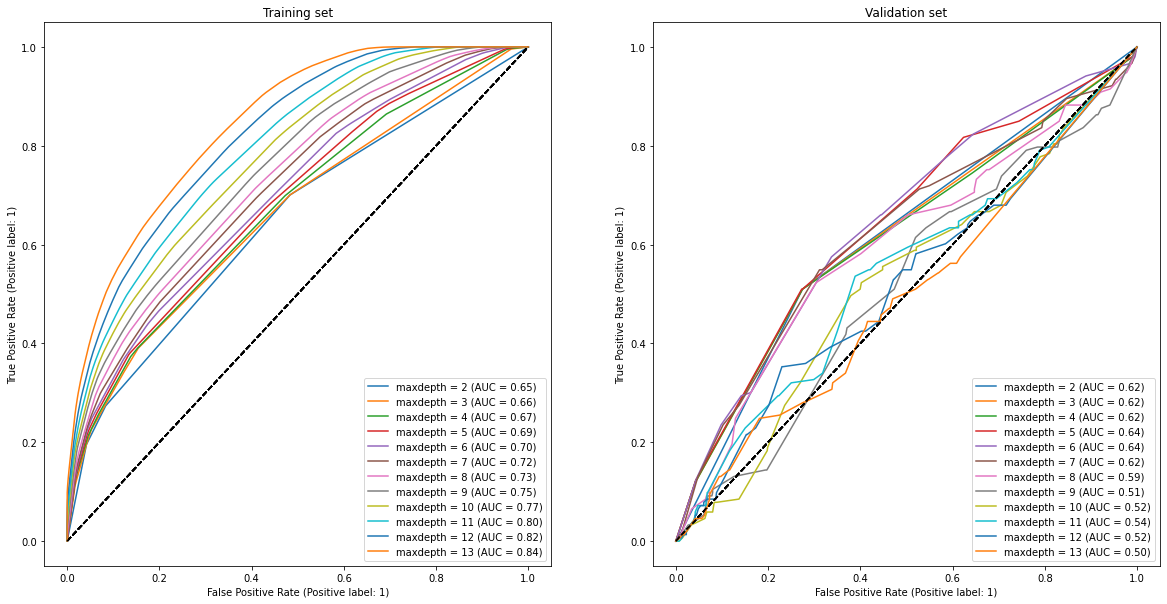

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,\
 roc_auc_score, plot_roc_curve,f1_score,\
  confusion_matrix, classification_report,\
  precision_recall_curve


# creating dictionaries to store metrics for different knn models
valid_acc = dict()
train_acc = dict()

valid_AUC = dict()
train_AUC = dict()

train_cm = dict()
valid_cm = dict()

train_f1 = dict()
valid_f1 = dict()

train_prc = dict()
valid_prc = dict()

train_proba1 = dict()
valid_proba1 = dict()


# create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))



depths = range(2,14)

for d in depths:
  print(f"Using max depth = {d}")
  DTCmodel = DecisionTreeClassifier(max_depth = d,class_weight='balanced') # intitalize a Decision tree classifier model with a new max depth
  DTCmodel.fit(Xq2train,yq2train) 

  # predicting on training and validation sets
  y_train_predicted = DTCmodel.predict(Xq2train) 
  y_valid_predicted = DTCmodel.predict(Xq2valid) 

  # soft predictions on training and validation data
  y_train_proba = DTCmodel.predict_proba(Xq2train) 
  y_valid_proba = DTCmodel.predict_proba(Xq2valid)

  # saving metrics for training and validayion data
  # calculate accuracy
  valid_acc[d] = accuracy_score(yq2valid, y_valid_predicted)
  train_acc[d] = accuracy_score(yq2train,y_train_predicted)

  # getting roc_auc scores for training and validation sets 
  valid_AUC[d] = roc_auc_score(yq2valid, y_valid_proba[:,1])
  train_AUC[d] = roc_auc_score(yq2train, y_train_proba[:,1])

  # getting confusion matrices
  valid_cm[d] = confusion_matrix(yq2valid, y_valid_predicted)
  train_cm[d] = confusion_matrix(yq2train, y_train_predicted)

  # F1 -scores
  valid_f1[d] = f1_score(yq2valid, y_valid_predicted)
  train_f1[d] = f1_score(yq2train, y_train_predicted)

  # precision recall curves
  valid_prc[d] = precision_recall_curve(yq2valid, y_valid_proba[:,1])
  train_prc[d] = precision_recall_curve(yq2train, y_train_proba[:,1])

  # saving probabilities of positive class
  valid_proba1[d] = y_valid_proba[:,1]
  train_proba1[d] = y_train_proba[:,1]

  # plot ROC curve for training and validation sets
  plot_roc_curve(DTCmodel, Xq2train, yq2train, ax=axes[0],name=f"maxdepth = {d}")
  plot_roc_curve(DTCmodel, Xq2valid, yq2valid, ax=axes[1],name=f"maxdepth = {d}")

  # Add line y=x and titls
  for axis_num, plot_title in enumerate(['Training set', 'Validation set']):
    axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
    axes[axis_num].set_title(plot_title)

plt.show()



In [44]:
dtree_metrics = pd.DataFrame()
dtree_metrics['valid_accuracy'] = pd.Series(valid_acc)
dtree_metrics['train_accuracy'] = pd.Series(train_acc)
dtree_metrics['valid_AUC'] = pd.Series(valid_AUC)
dtree_metrics['train_AUC'] = pd.Series(train_AUC)
dtree_metrics['valid_f1'] = pd.Series(valid_f1)
dtree_metrics['train_f1'] = pd.Series(train_f1)
dtree_metrics = dtree_metrics.reset_index()
dtree_metrics['Max_depth'] = dtree_metrics['index']
dtree_metrics = dtree_metrics.drop('index',axis=1)
display(np.around(dtree_metrics,2))

,valid_accuracy,train_accuracy,valid_AUC,train_AUC,valid_f1,train_f1,Max_depth
0,0.70,0.54,0.62,0.65,0.28,0.32,2
1,0.86,0.78,0.62,0.66,0.17,0.35,3
2,0.86,0.78,0.62,0.67,0.17,0.35,4
3,0.86,0.79,0.64,0.69,0.17,0.36,5
4,0.79,0.75,0.64,0.70,0.25,0.36,6
5,0.67,0.61,0.62,0.72,0.28,0.35,7
6,0.68,0.61,0.59,0.73,0.27,0.36,8
7,0.61,0.62,0.51,0.75,0.20,0.37,9
8,0.71,0.74,0.52,0.77,0.18,0.41,10
9,0.66,0.69,0.54,0.80,0.18,0.42,11


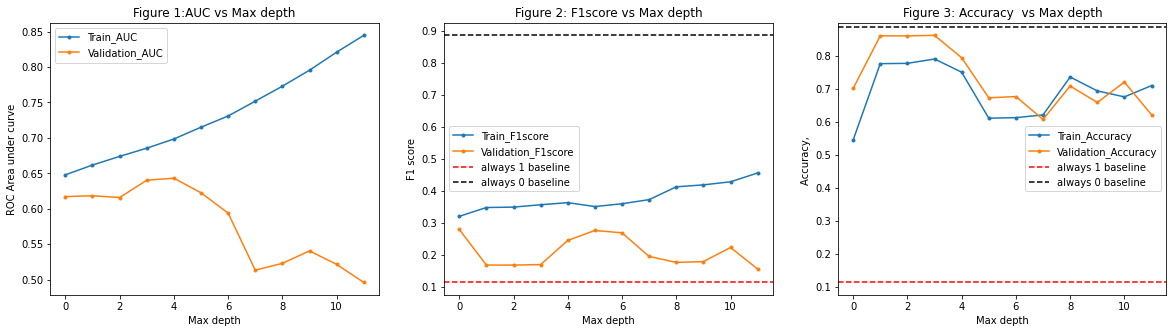

In [45]:
y_valid = yq2valid
y_train = yq2train

plt.subplots(1,3,figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(dtree_metrics['train_AUC'],'.-',label='Train_AUC')
plt.plot(dtree_metrics['valid_AUC'],'.-',label='Validation_AUC')
plt.title("Figure 1:AUC vs Max depth")
plt.xlabel("Max depth")
plt.ylabel("ROC Area under curve")
plt.legend()

plt.subplot(1,3,2)
plt.plot(dtree_metrics['train_f1'],'.-',label='Train_F1score')
plt.plot(dtree_metrics['valid_f1'],'.-',label='Validation_F1score')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_f1 = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_f1 = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_f1,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_f1,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("F1 score")
plt.title("Figure 2: F1score vs Max depth")
plt.legend()

plt.subplot(1,3,3)
plt.plot(dtree_metrics['train_accuracy'],'.-',label='Train_Accuracy')
plt.plot(dtree_metrics['valid_accuracy'],'.-',label='Validation_Accuracy')
# getting accuracy for baseline model that always predicts 1 no matter what.
baseline1_acc = accuracy_score(y_valid, [1]*y_valid.shape[0])
# getting accuracy for baseline model that always predicts 0 no matter what.
baseline0_acc = accuracy_score(y_valid, [0]*y_valid.shape[0])
plt.axhline(baseline1_acc,color = 'red',linestyle = '--',label="always 1 baseline")
plt.axhline(baseline0_acc,color = 'black',linestyle = '--',label="always 0 baseline")
plt.xlabel("Max depth")
plt.ylabel("Accuracy, ")
plt.title("Figure 3: Accuracy  vs Max depth")
plt.legend()

plt.show()

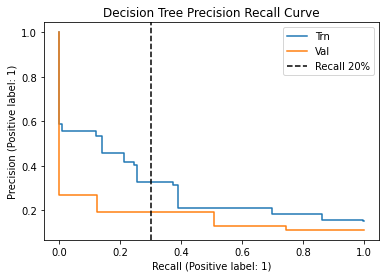

In [46]:
precision3, recall3, thresholds3 = precision_recall_curve(y_valid,valid_proba1[4])
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(y_train,train_proba1[4])
plt.figure()
ax =plt.gca()
PrecisionRecallDisplay.from_predictions(y_train,train_proba1[4], ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(y_valid,valid_proba1[4], ax=ax,label="Val")

plt.title("Decision Tree Precision Recall Curve")
#precision_at_recall2 = np.interp(x= 0.3,xp = precision2[int(0.1*len(recall2)):int(0.8*len(recall2))],fp = recall2[int(0.1*len(recall2)):int(0.8*len(recall2))])
precision_at_recall3 = np.interp(x= 0.3,fp = precision3,xp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,fp = precision3_t,xp = recall3_t)
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall-Val 30% = 20%")
#plt.axhline(precision_at_recall3_t,color='green',linestyle = '--',label = f"Precision at Recall-Trn 30% = 20%")
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 20%')
plt.legend()
plt.show()

The model with student based features only is still at the baseline levels. 

## <font color = 'cornflowerblue' size=4>Ensemble models</font>

### <font color = 'cornflowerblue' size=3>XGBoost</font>

In [47]:
from xgboost import XGBClassifier


XGB_model = XGBClassifier(num_feature = 100,subsample = 0.6)
XGB_model.fit(Xq2_train_mm,yq2train)
print(f"XG Boost train set score: {XGB_model.score(Xq2_train_mm,yq2train)}")
print(f"XG Boost val set score: {XGB_model.score(Xq2_valid_mm,yq2valid)}")

XG Boost train set score: 0.8529640706296858
XG Boost val set score: 0.8861607142857143


In [48]:
yq2_train_preds_probs_xgb = XGB_model.predict_proba(Xq2_train_mm)[:,1]
yq2_valid_preds_probs_xgb = XGB_model.predict_proba(Xq2_valid_mm)[:,1]


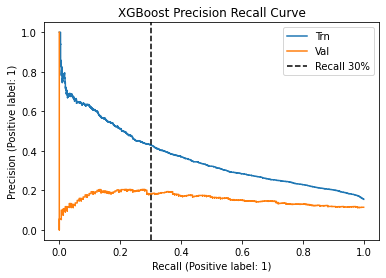

In [51]:
# calculating precision, recall and thresholds for the model
precision3, recall3, thresholds3 = precision_recall_curve(yq2valid, yq2_valid_preds_probs_xgb)
precision3_t, recall3_t, thresholds3_t = precision_recall_curve(yq2train, yq2_train_preds_probs_xgb)


# plotting precision recall curve and calling out precision at 30% recall
plt.figure()
ax =plt.gca()
# plotting precision-recall curve
PrecisionRecallDisplay.from_predictions(yq2train,yq2_train_preds_probs_xgb, ax=ax,label="Trn")
PrecisionRecallDisplay.from_predictions(yq2valid,yq2_valid_preds_probs_xgb, ax=ax,label="Val")

plt.title("XGBoost Precision Recall Curve")

# interpolating to find precision at recall = 30%
precision_at_recall3 = np.interp(x= 0.3,xp = precision3,fp = recall3)
precision_at_recall3_t = np.interp(x= 0.3,xp = precision3_t,fp = recall3_t)

# plotting vertical line for recall = 0.3
plt.axvline(0.3,color='black',linestyle='--',label = 'Recall 30%')

# plotting horizontal line for precision at recall = 0.3, label with rounded precision number
#plt.axhline(precision_at_recall3,color='green',linestyle = '--',label = f"Precision at Recall 30% = {np.around(precision_at_recall2*100,2)}%")

plt.legend()
plt.show()

The validation precision-recall curve is not improved much by XGBoost.

In [52]:
XGB_feature_importances = pd.Series(XGB_model.feature_importances_,index=Xq2train.columns)
XGB_feature_importances.sort_values(ascending=False).head(20)

avg_history_frac         0.084555
avgp_forgot_day          0.073029
mod_x0_pro               0.055037
history_frac             0.041086
mod_x0_pri               0.031823
pos_x0_n                 0.031058
mod_x0_sp                0.029347
mod_x0_p2                0.026144
mod_x0_*numb             0.024971
mod_x0_*pers             0.023210
mod_x0_p3                0.022545
pos_x0_prn               0.022337
numwordspracticed_day    0.021957
history_seen             0.021818
mod_x0_pos               0.020934
mod_x0_@past             0.020902
simoverdiff              0.020633
avgdelta_day             0.020392
mod_x0_sg                0.019927
delta                    0.019242
dtype: float32

Ensemble techniques show a slight improvement in precision in the zone where recall is low. It is training to specific cases, possibly for a certain predictable set of students. 

## <font color='cornflowerblue' size=4>Neural nets</font>

In [53]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [54]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [55]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [56]:
from tensorflow import keras
from tensorflow.keras import layers

In [63]:
# Create a new sequential model
model = tf.keras.Sequential()

regularizer = keras.regularizers.l2(0.001)

# Declare the hidden layers
model.add(layers.Dense(124, activation="relu",kernel_regularizer=regularizer))

model.add(layers.Dense(64, activation="relu",kernel_regularizer=regularizer))
model.add(layers.Dense(32, activation="relu",kernel_regularizer=regularizer))
model.add(layers.Dense(4, activation="relu",kernel_regularizer=regularizer))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [64]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
     
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.3)]
)

In [68]:
history = model.fit(Xq2_train_mm,np.array(yq2train), epochs=20, verbose=1, batch_size=500,validation_data = (Xq2_valid_mm,np.array(yq2valid)))

Epoch 1/20
49/49 [==============================] - 0s 5ms/step - loss: 0.4059 - precision_at_recall_1: 0.3578 - val_loss: 0.3559 - val_precision_at_recall_1: 0.2188
Epoch 2/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4056 - precision_at_recall_1: 0.3612 - val_loss: 0.3603 - val_precision_at_recall_1: 0.1913
Epoch 3/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4054 - precision_at_recall_1: 0.3621 - val_loss: 0.3577 - val_precision_at_recall_1: 0.2032
Epoch 4/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4051 - precision_at_recall_1: 0.3564 - val_loss: 0.3557 - val_precision_at_recall_1: 0.1958
Epoch 5/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4052 - precision_at_recall_1: 0.3492 - val_loss: 0.3545 - val_precision_at_recall_1: 0.1976
Epoch 6/20
49/49 [==============================] - 0s 4ms/step - loss: 0.4046 - precision_at_recall_1: 0.3614 - val_loss: 0.3553 - val_precision_at_recall_1: 0.1967
Epoc

In [69]:
history.history.keys()

dict_keys(['loss', 'precision_at_recall_1', 'val_loss', 'val_precision_at_recall_1'])

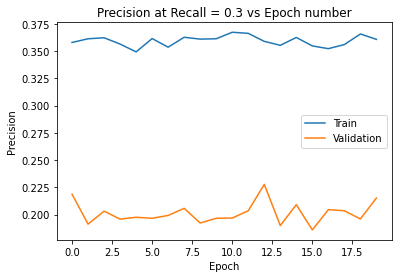

In [70]:
plt.plot(history.history['precision_at_recall_1'])
plt.plot(history.history['val_precision_at_recall_1'])
plt.title('Precision at Recall = 0.3 vs Epoch number')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

The model is overfitting to the training set. 

This feature set is probably suffering from the curse of dimensionality.

The next round of modeling will get rid of the one hor encoded morphological data, leaving only the derived word features in addition to the student based features. 